# Generated Vs. Real Image Classification

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Data Preparation

In [84]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow import keras
from tensorflow.keras.layers import (
    Activation,
    Add,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import image_dataset_from_directory

tf.config.list_physical_devices("GPU")

[]

### Load Data

In [2]:
train_img, test_img = image_dataset_from_directory(
    directory="images",
    label_mode="binary",
    image_size=(32, 32),
    seed=7324,
    validation_split=0.2,
    subset="both",
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


### Data Splitting Justification

We decided to use an 80/20 train/test split for our dataset. We chose a split over cross-validation because we have more than enough data (100,000 images) to train our model effectively while also reserving a significant portion for testing. This technique more closely mimics how the model would be used in a real-world scenario, because it is predicting completely unseen data. Typically, cross-validation is reserved for smaller datasets, where the model needs to be trained on the whole dataset to generalize well. This is not the case for our dataset, and cross-validation would significantly increase the time it would take to train our model.

### Performance Metrics Justification

While we will consider a suite of metrics to evaluate our model, we will focus on ROC AUC as our primary metric. This is because it provides a comprehensive view of the model's performance. We will also consider accuracy, precision, and recall to provide additional context and understanding of the model's performance. We opted for AUC as our primary metric over precision and recall (which measure a model's aptitude for false positives and false negatives) because we are more interested in the model's overall ability to distinguish between real and generated images, rather than its performance for a specific class. This is because any business use cases would most likely consider false predictions for both classes equally bad, and we want to ensure that the model is robust across both classes.

## Modeling

### Data Augmentation Justification

We will use both `RandomContrast` and `RandomRotation` augmentation techniques. Because we have color images, we want to ensure that our model is robust to changes in color and brightness (thus, `RandomContrast`). We also want to ensure that our model is robust to changes in orientation, as this can significantly impact the model's performance (thus, `RandomRotation`). This way, we have one color augmentation and one position augmentation, which will help our model generalize better to unseen data.

### Model Architecture 1

In [3]:
cnn1 = Sequential()
# Data augmentation
cnn1.add(RandomContrast(factor=0.5, seed=7324))
cnn1.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn1.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
)
cnn1.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn1.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn1.add(Flatten())
# Fully connected layers
cnn1.add(Dense(64, activation="relu"))
# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn1.add(Dense(1, activation="sigmoid"))

In [4]:
cnn1.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [27]:
# cnn1_history = cnn1.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn1_history.pickle", "rb") as handle:
    cnn1_history = pickle.load(handle)


In [71]:
def plot_metrics(history_obj: tf.keras.callbacks.History) -> None:
    """Plot all metrics in the model history.

    Parameters
    ----------
    history_obj : History
        The history object returned by the fit method of the model.

    """
    metrics = [
        key for key in history_obj.history if not key.startswith("val_")
    ]
    num_metrics = len(metrics)
    plt.figure(figsize=(15, 5 * ((num_metrics + 1) // 2)))

    for i, metric in enumerate(metrics, 1):
        plt.subplot((num_metrics + 1) // 2, 2, i)
        plt.plot(history_obj.history[metric], label="training")
        plt.plot(history_obj.history[f"val_{metric}"], label="validation")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


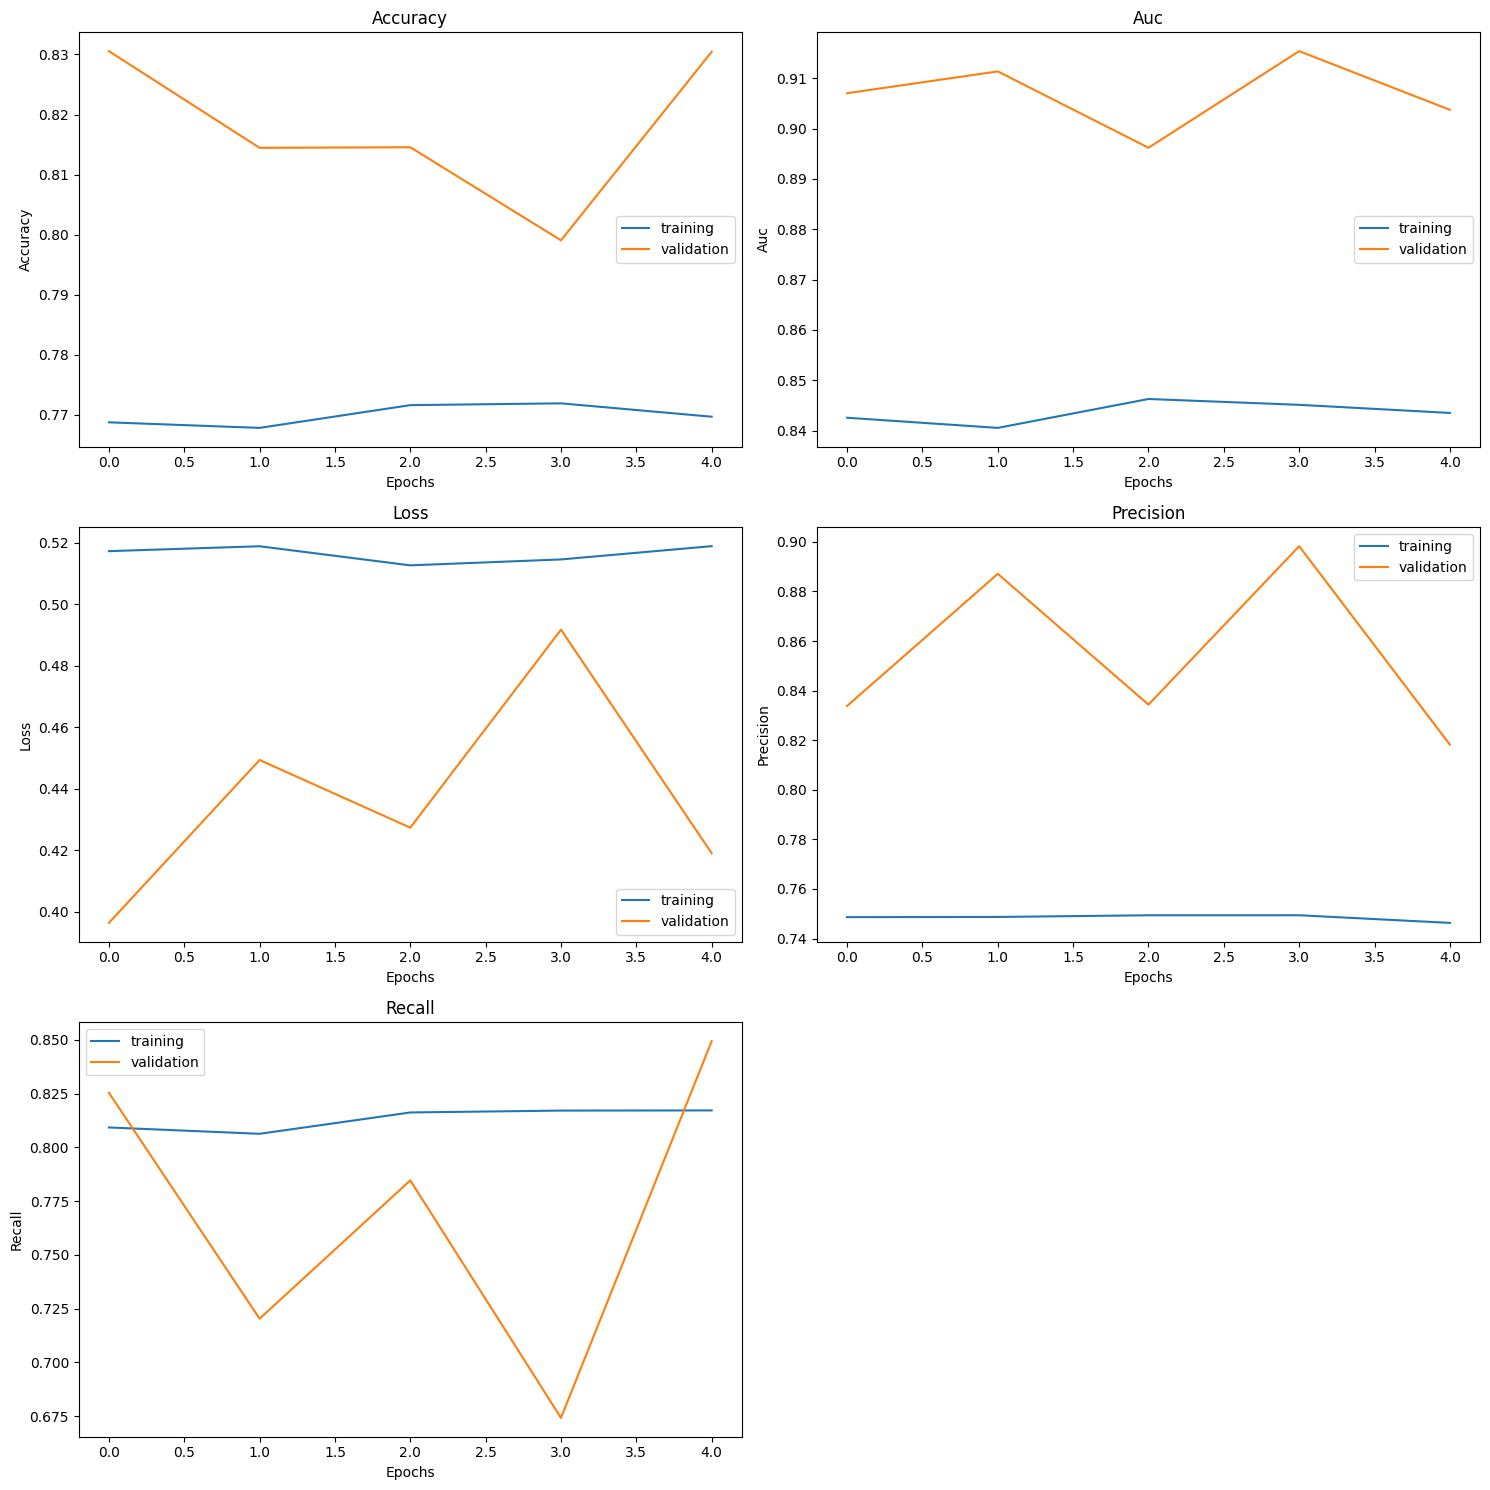

In [72]:
plot_metrics(cnn1_history)

In [ ]:
# cnn1.save("models/cnn1.keras")
# with Path.open("histories/cnn1_history.pickle", "wb") as handle:
#     pickle.dump(cnn1_history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [12]:
cnn2 = Sequential()
# Data augmentation
cnn2.add(RandomContrast(factor=0.5, seed=7324))
cnn2.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn2.add(
    Conv2D(
        filters=32,
        kernel_size=(2, 2),
        activation="relu",
        padding="same",
    ),
)
cnn2.add(
    Conv2D(
        filters=64,
        kernel_size=(2, 2),
        padding="same",
        activation="relu",
    ),
)
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn2.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn2.add(Flatten())
# Fully connected layers
cnn2.add(Dense(32, activation="relu"))
# Add some dropout for regularization
cnn2.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn2.add(Dense(1, activation="sigmoid"))

In [13]:
cnn2.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [31]:
# cnn2_history = cnn2.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn2_history.pickle", "rb") as handle:
    cnn2_history = pickle.load(handle)

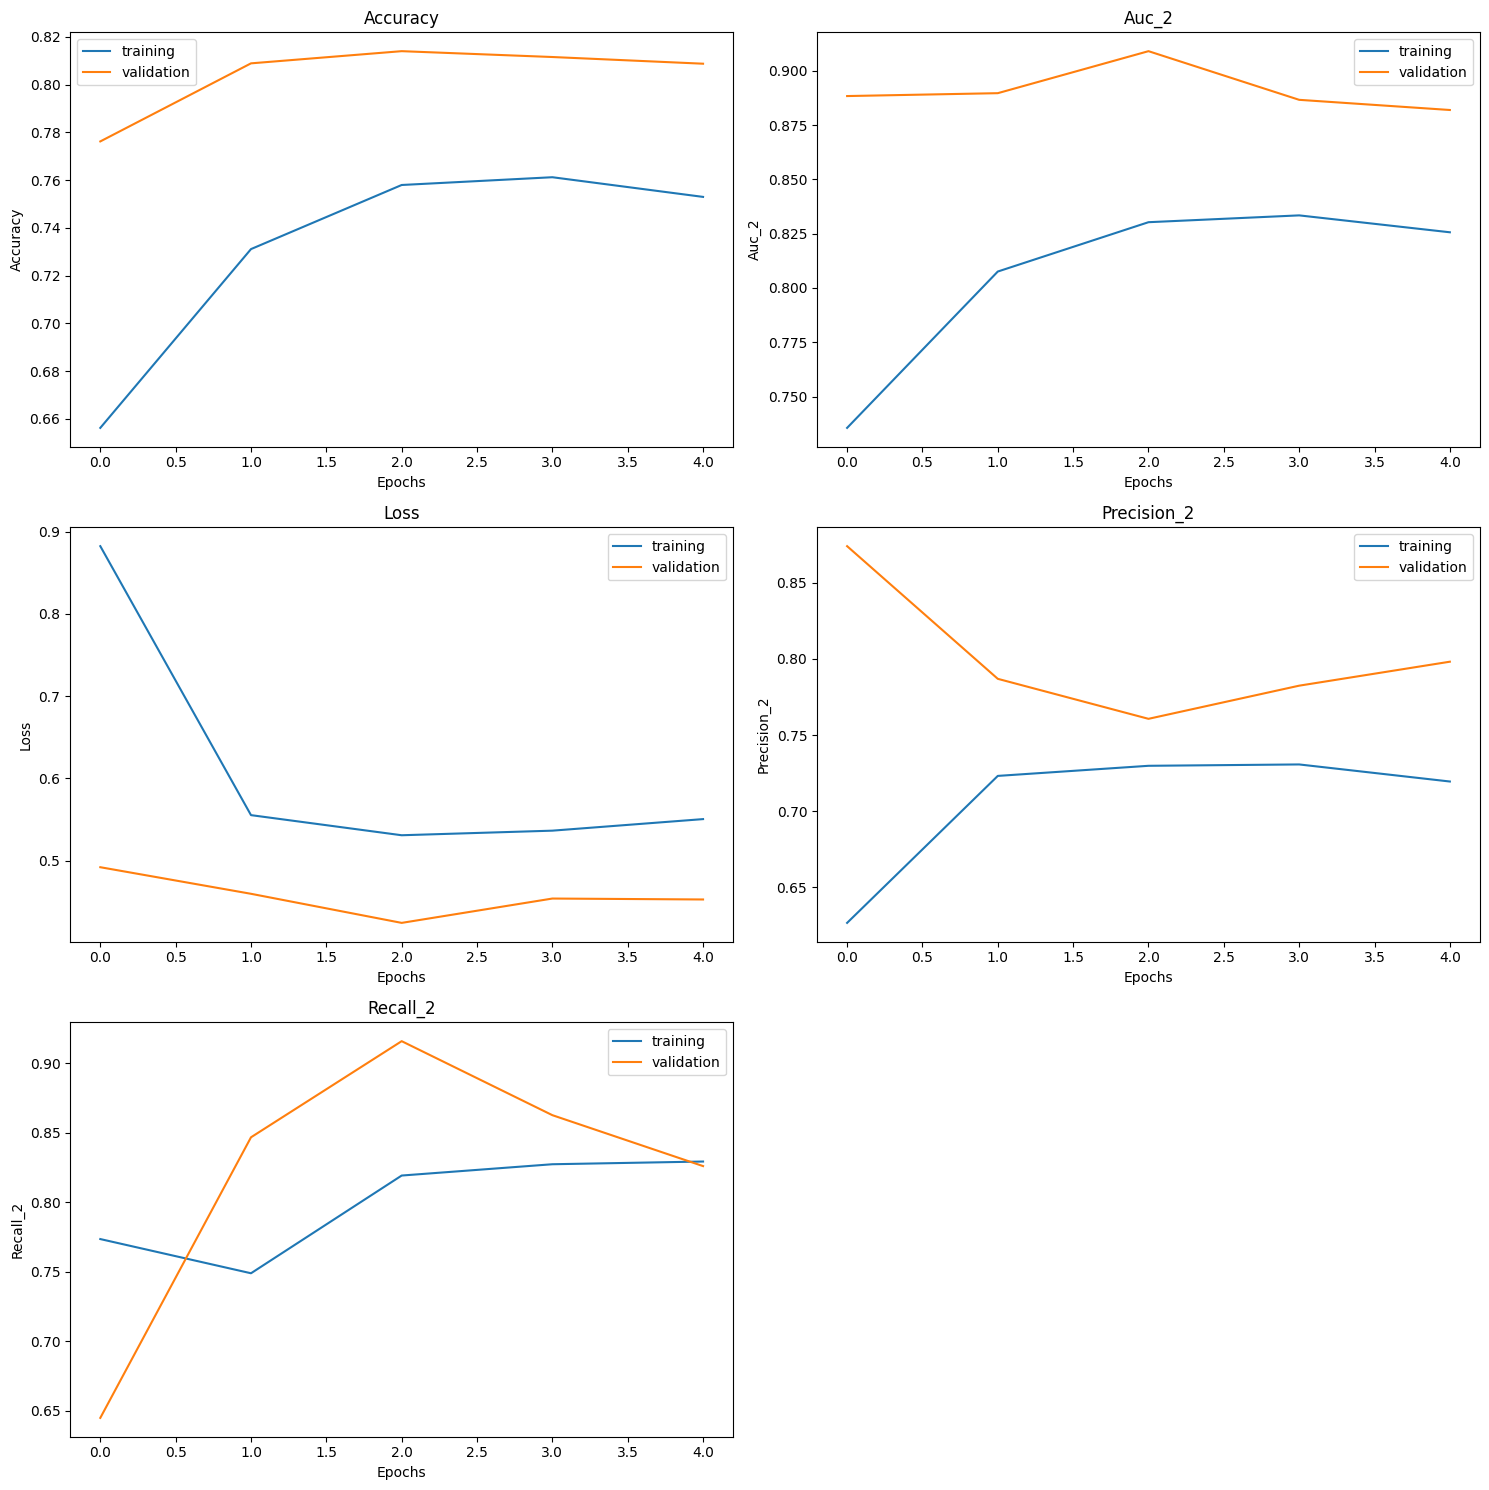

In [67]:
plot_metrics(cnn2_history)

In [ ]:
# cnn2.save("models/cnn2.keras")
# with Path.open("histories/cnn2_history.pickle", "wb") as handle:
#     pickle.dump(cnn2_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
cnn3 = Sequential()
# Data augmentation
cnn3.add(RandomContrast(factor=0.5, seed=7324))
cnn3.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn3.add(
    Conv2D(
        filters=32,
        kernel_size=(1, 1),
        activation="relu",
        padding="same",
    ),
)
cnn3.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn3.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn3.add(Flatten())
# Fully connected layers
cnn3.add(Dense(32, activation="relu"))
# Add some dropout for regularization
cnn3.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn3.add(Dense(1, activation="sigmoid"))

In [34]:
cnn3.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [38]:
# cnn3_history = cnn3.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn3_history.pickle", "rb") as handle:
    cnn3_history = pickle.load(handle)

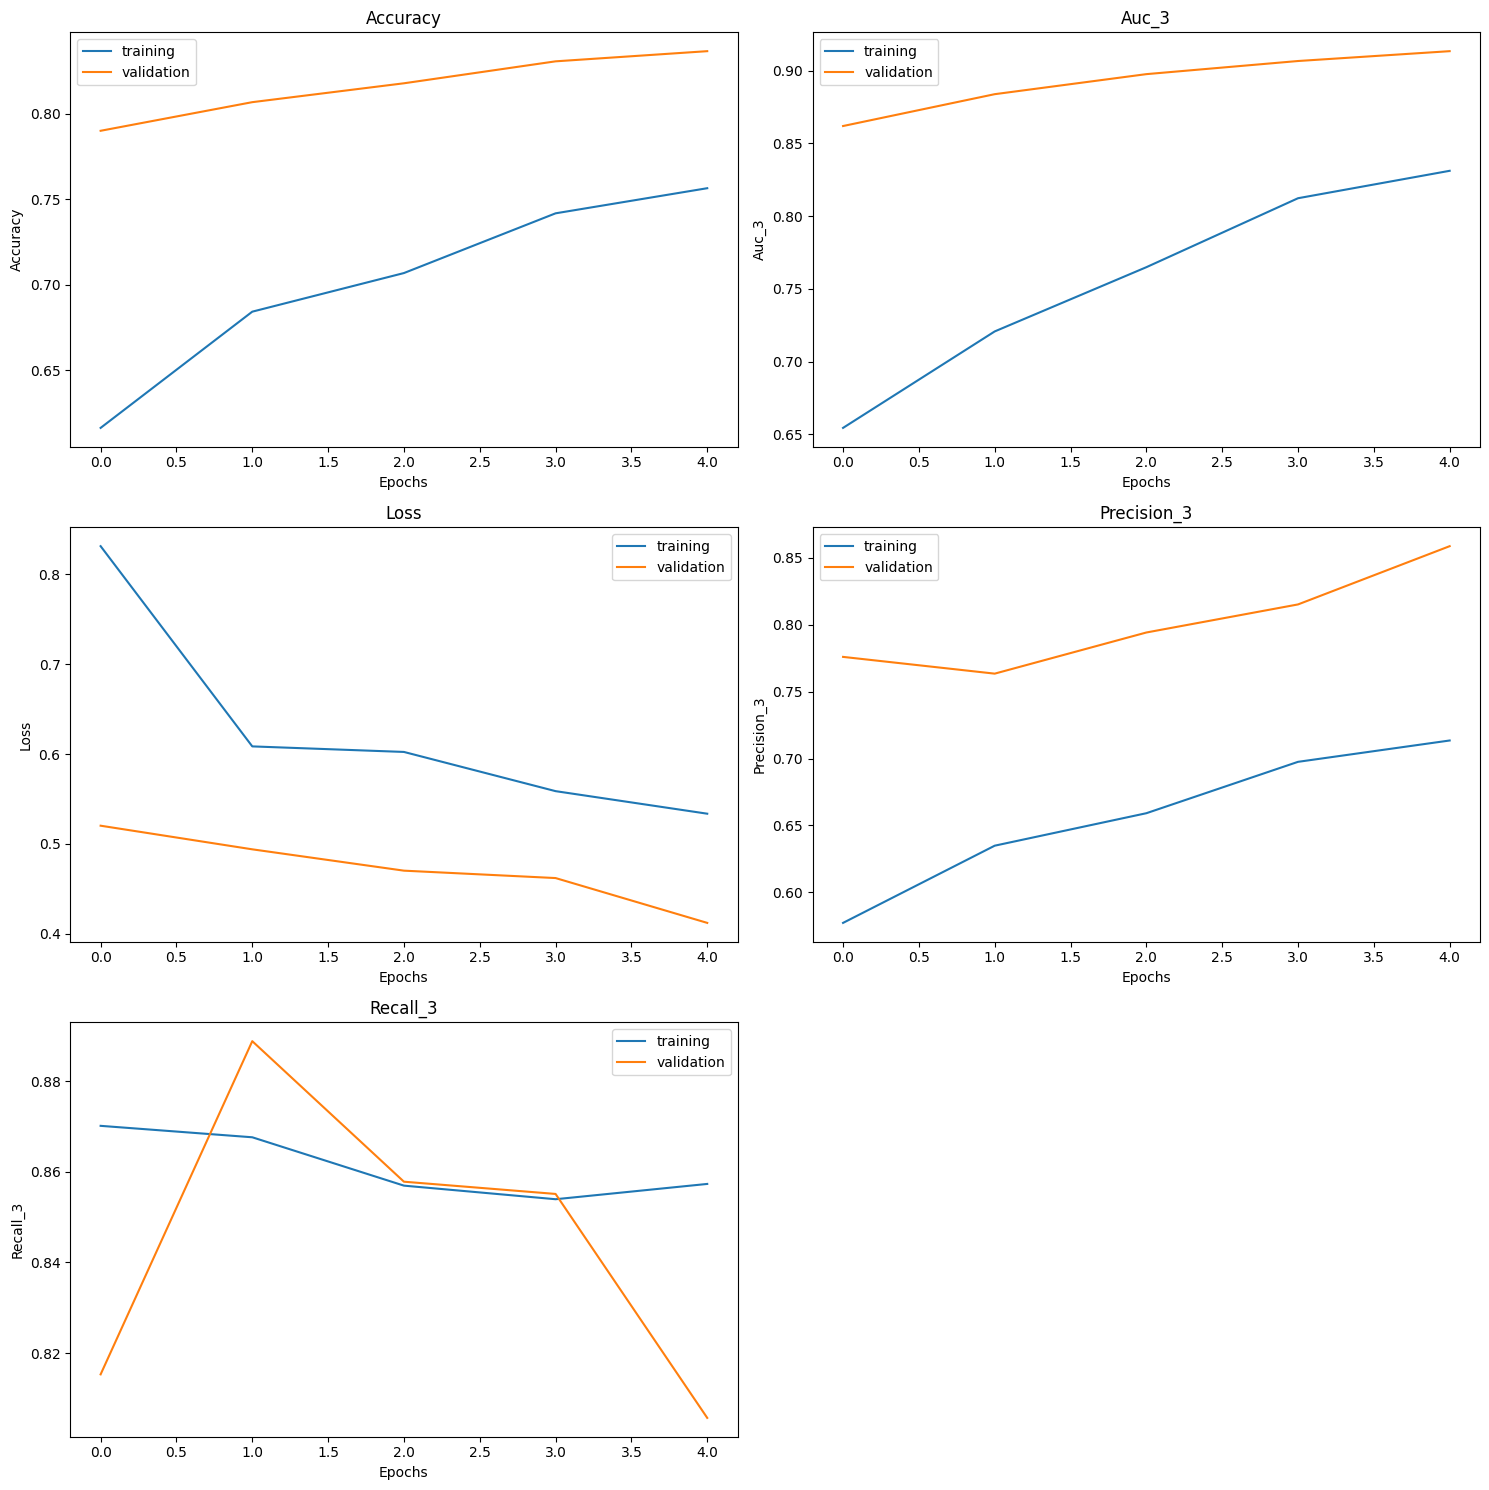

In [68]:
plot_metrics(cnn3_history)

In [ ]:
# cnn3.save("models/cnn3.keras")
# with Path.open("histories/cnn3_history.pickle", "wb") as handle:
#     pickle.dump(cnn3_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Model Architecture 2

In [40]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# start with a conv layer
x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x_split)

x = Conv2D(
    filters=64,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x)

# Add split back in
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

resnet1 = Model(inputs=input_holder, outputs=x)

In [41]:
resnet1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [45]:
# resnet1_history = resnet1.fit(
#     train_img,
#     batch_size=32,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/resnet1_history.pickle", "rb") as handle:
    resnet1_history = pickle.load(handle)

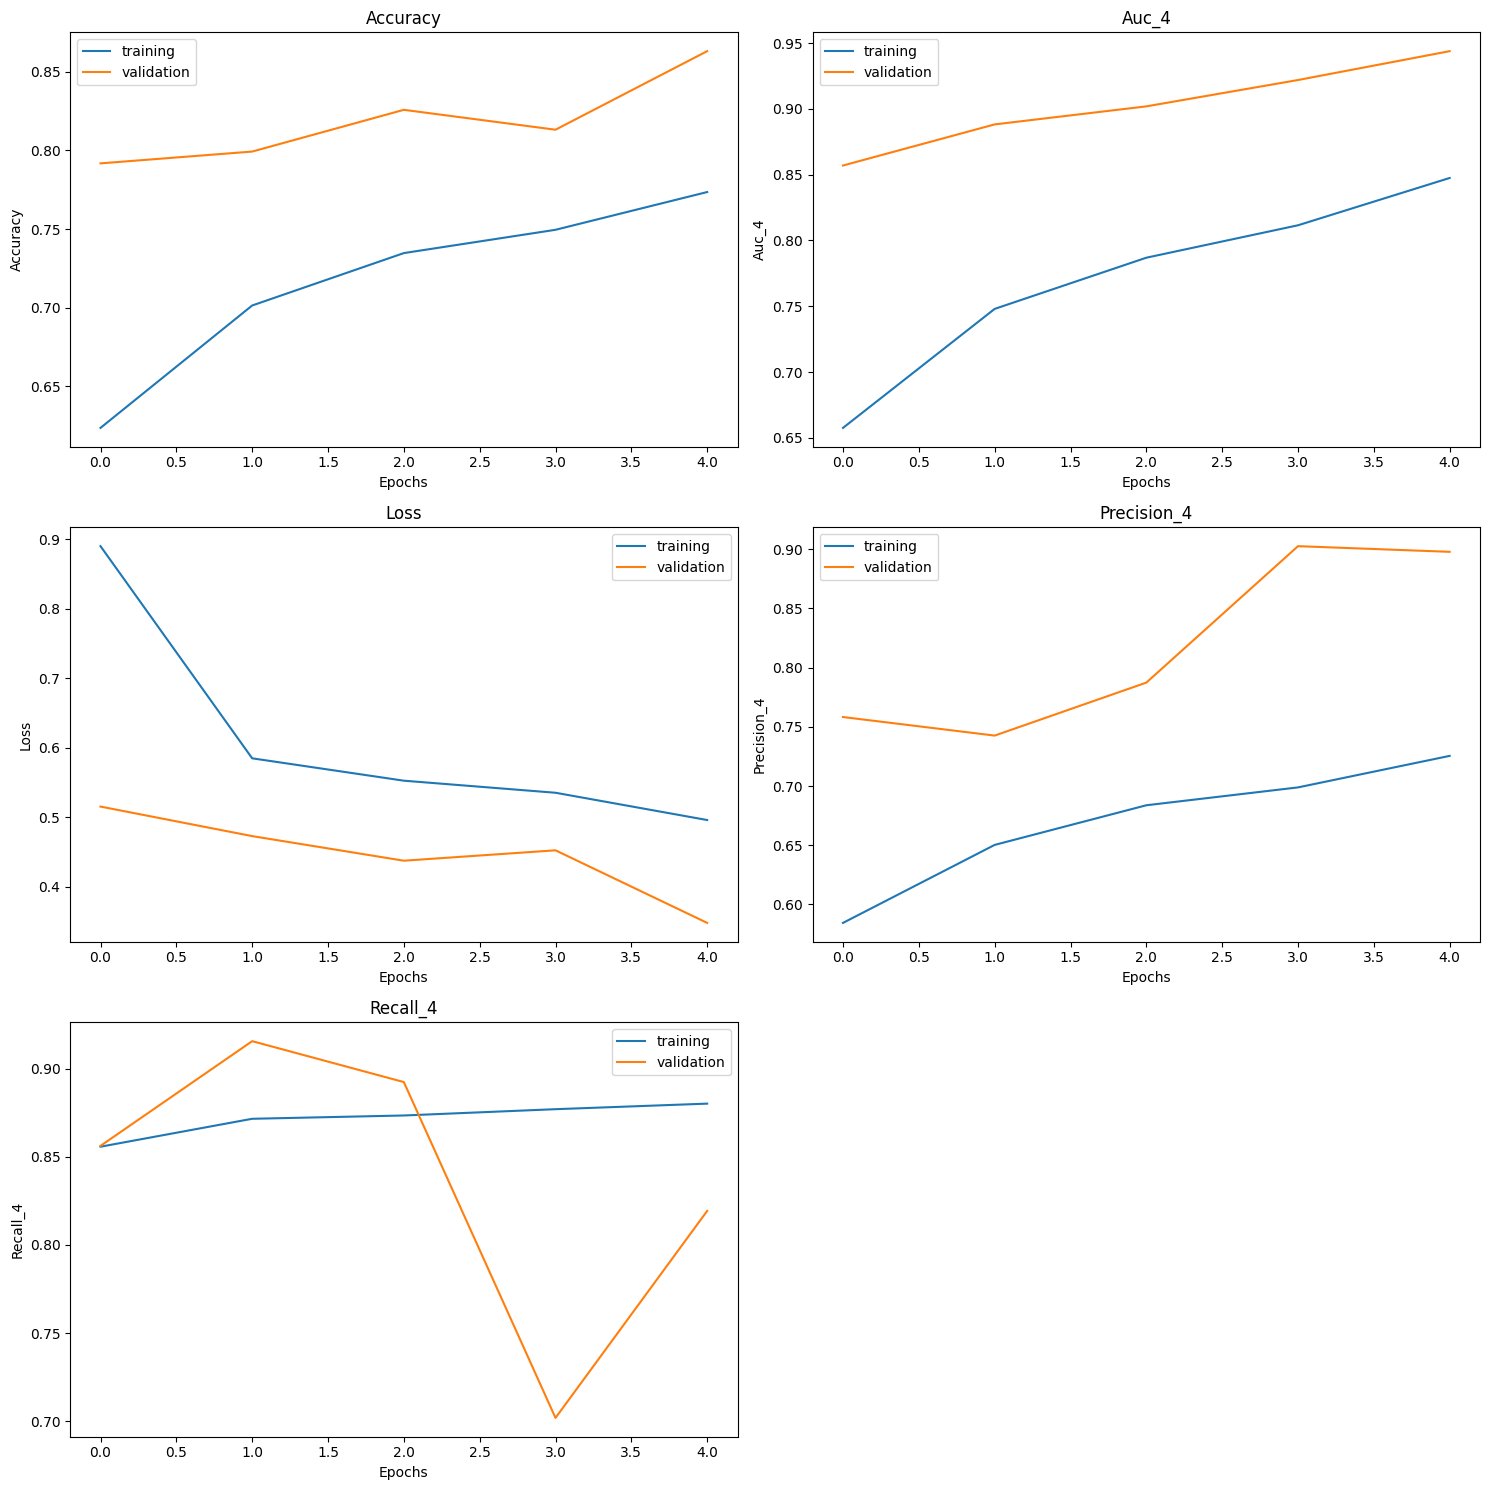

In [69]:
plot_metrics(resnet1_history)

In [ ]:
# resnet1.save("models/resnet1.keras")
# with Path.open("histories/resnet1_history.pickle", "wb") as handle:
#     pickle.dump(resnet1_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# start with a conv layer
x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x_split)

x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x)

# Add split back in
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

resnet2 = Model(inputs=input_holder, outputs=x)

In [48]:
resnet2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [52]:
# resnet2_history = resnet2.fit(
#     train_img,
#     batch_size=32,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/resnet2_history.pickle", "rb") as handle:
    resnet2_history = pickle.load(handle)

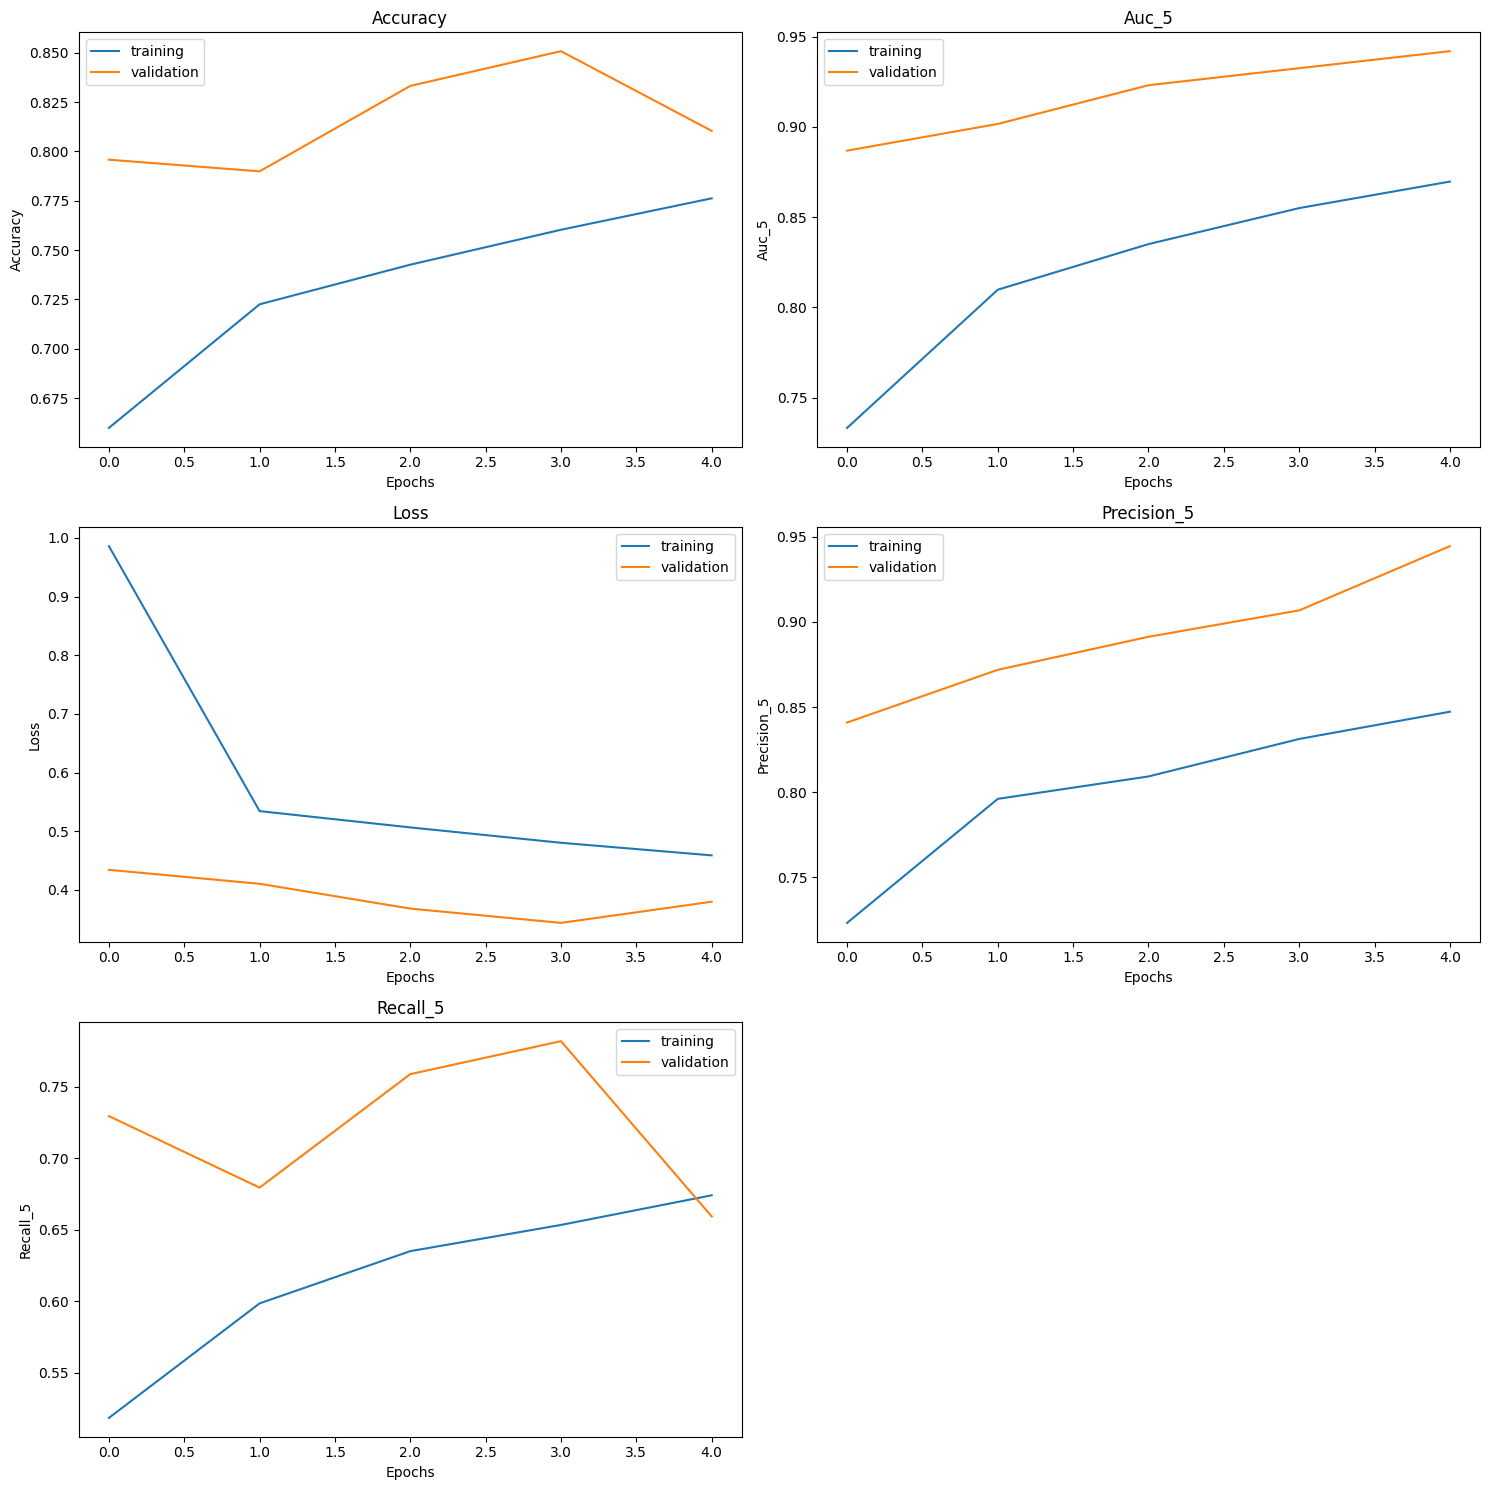

In [70]:
plot_metrics(resnet2_history)

In [ ]:
# resnet2.save("models/resnet2.keras")
# with Path.open("histories/resnet2_history.pickle", "wb") as handle:
#     pickle.dump(resnet2_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Model Comparison

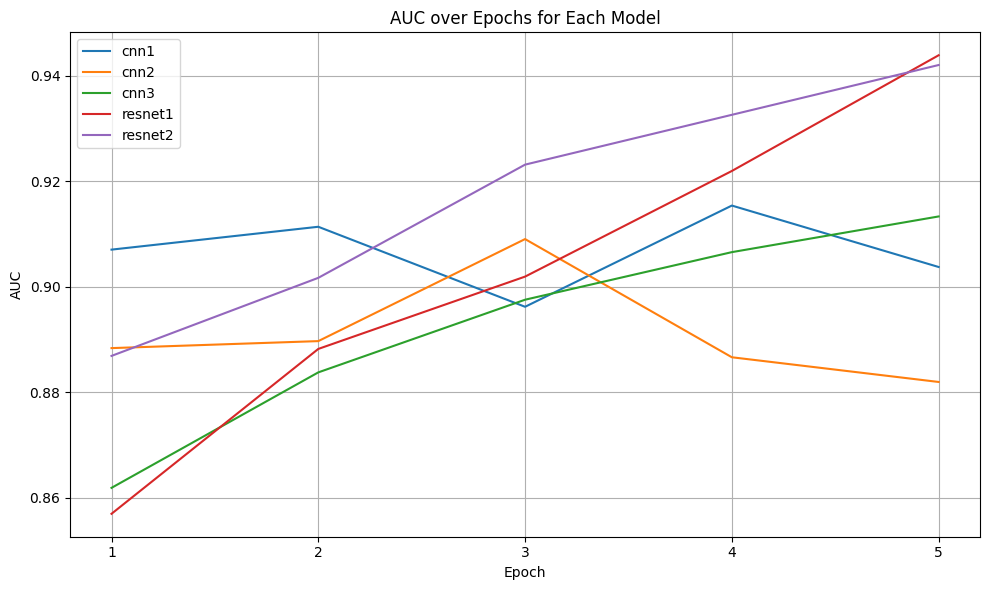

In [106]:
plt.figure(figsize=(10, 6))

auc_histories = {
    "cnn1": cnn1_history.history["val_auc"],
    "cnn2": cnn2_history.history["val_auc_2"],
    "cnn3": cnn3_history.history["val_auc_3"],
    "resnet1": resnet1_history.history["val_auc_4"],
    "resnet2": resnet2_history.history["val_auc_5"],
}

for model_name, auc_values in auc_histories.items():
    plt.plot(range(1, len(auc_values) + 1), auc_values, label=model_name)

plt.title("AUC over Epochs for Each Model")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
def mcnemar_test(model1: keras.Model, model2: keras.Model) -> None:
    """Perform McNemar's test to compare two models.

    Parameters
    ----------
    model1 : keras.Model
        The first Keras model to compare.
    model2 : keras.Model
        The second Keras model to compare.

    Returns
    -------
    None
        Prints the results of the McNemar's test.

    """
    yhat1_proba = model1.predict(test_img)
    yhat1 = np.where(yhat1_proba > 0.5, 1, 0).ravel()

    yhat2_proba = model2.predict(test_img)
    yhat2 = np.where(yhat2_proba > 0.5, 1, 0).ravel()

    # Create a contingency table
    contingency_table = pd.crosstab(
        pd.Series(yhat1, name="Model 1"),
        pd.Series(yhat2, name="Model 2"),
    )

    # Perform McNemar's test
    result = mcnemar(contingency_table, exact=True)

    print("McNemar's Test Results:")
    print(f"Statistic: {result.statistic}")
    print(f"P-value: {result.pvalue}")

In [98]:
mcnemar_test(cnn1, cnn2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
McNemar's Test Results:
Statistic: 1470.0
P-value: 0.5696079040838625


In [112]:
mcnemar_test(cnn2, cnn3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
McNemar's Test Results:
Statistic: 901.0
P-value: 7.875848266829601e-77


In [113]:
mcnemar_test(cnn3, resnet1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
McNemar's Test Results:
Statistic: 1221.0
P-value: 8.978019900152105e-07


In [114]:
mcnemar_test(resnet1, resnet2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
McNemar's Test Results:
Statistic: 308.0
P-value: 0.0


### CNN vs. MLP

In [128]:
mlp = Sequential()
mlp.add(Input(shape=(32, 32, 3)))
mlp.add(RandomContrast(factor=0.5, seed=7324))
mlp.add(RandomRotation(factor=0.5, seed=7324))
mlp.add(Flatten())
mlp.add(Dense(256, activation="relu"))
mlp.add(Dense(128, activation="relu"))
mlp.add(Dense(64, activation="relu"))
mlp.add(Dense(32, activation="relu"))
mlp.add(Dense(1, activation="sigmoid"))

In [129]:
mlp.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [133]:
# mlp_history = mlp.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/mlp_history.pickle", "rb") as handle:
    mlp_history = pickle.load(handle)

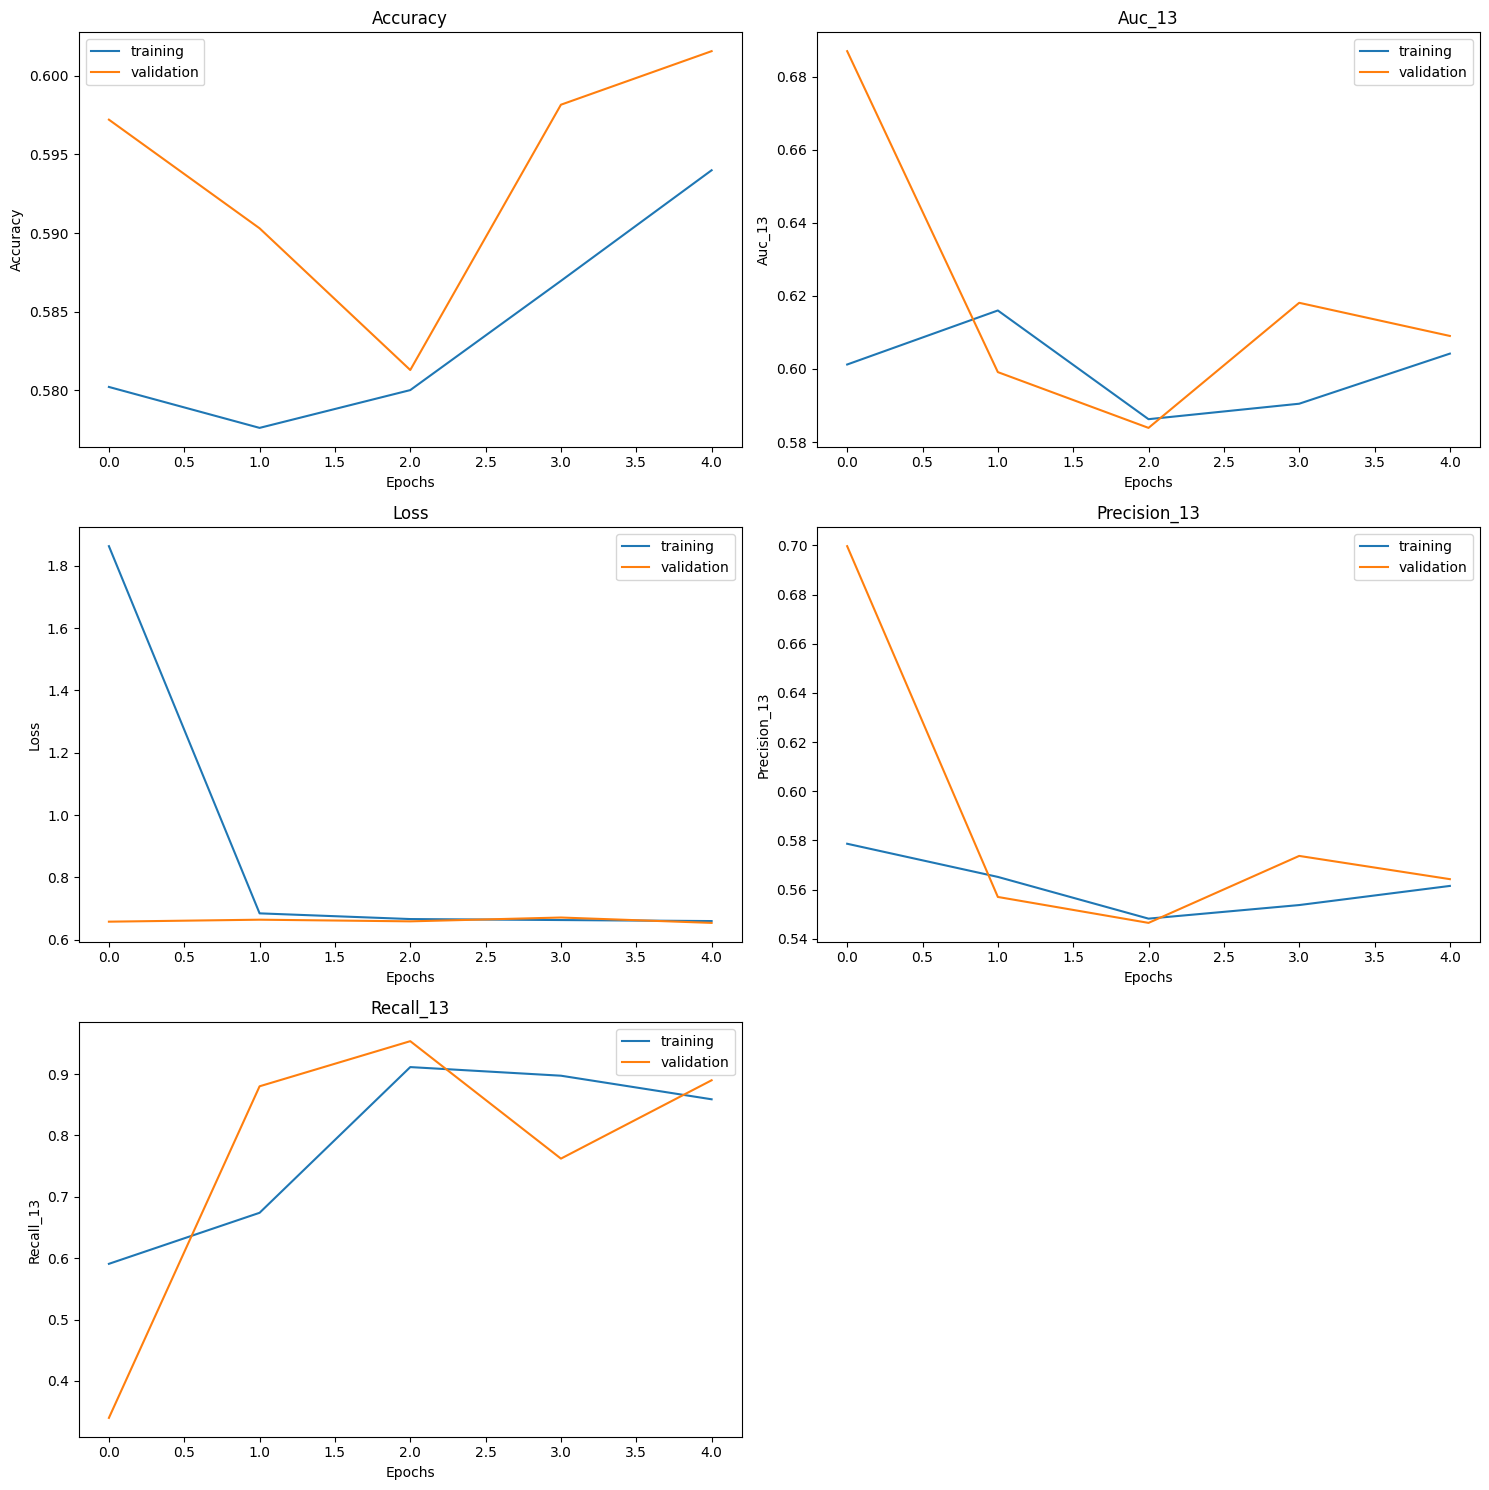

In [134]:
plot_metrics(mlp_history)

In [ ]:
# mlp.save("models/mlp.keras")
# with Path.open("histories/mlp_history.pickle", "wb") as handle:
#     pickle.dump(mlp_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Using Transfer Learning with Pre-Trained Models

ADD HERE